# Usage Guide : pygtm
## trajectories

In [1]:
import sys
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset

%matplotlib inline

In [2]:
sys.path.insert(0, "../")
from pygtm.dataset import trajectory


# Load drifter trajectories
## Using the drogued drifters in GDP database in the North Atlantic ([*download* data here](https://miamiedu-my.sharepoint.com/:u:/g/personal/pxm498_miami_edu/EfaPVkKsPABJrJtKyctKrAUBpp7XzNHHrOLUhFow3pMkZw?e=MXzrcG)) and ([notebook](https://github.com/philippemiron/notebooks/blob/master/gdp.ipynb) for more info)

In [3]:
filename = "data/gdp-north-atlantic-drogued.mat"
with Dataset(filename, "r") as f:
    d_id = f["id"][0]
    x = f["x"][0]  # [deg]
    y = f["y"][0]  # [deg]
    t = f["t"][0]  # [day]
del f

# drifter IDs are reused in the GDP so you make sure
# there isn't more than 10d before data points of a
# same drifter ID
I = np.where(abs(np.diff(d_id, axis=0)) > 0)[0]
I = np.insert(I, [0, len(I)], [-1, len(d_id) - 1])
max_id = np.max(d_id)

for i in range(0, len(I) - 1):
    range_i = np.arange(I[i] + 1, I[i + 1] + 1)
    t_diff = np.diff(t[range_i])

    # if there is a big gap, I changed the id and
    # treat the new segments as another drifters
    jump = np.where(t_diff > 10)[0]  # 10 days
    if len(jump) > 0:
        jump = np.insert(jump, [0, len(jump)], [-1, len(range_i) - 1])

        for j in range(0, len(jump) - 1):
            range_j = np.arange(jump[j] + 1, jump[j + 1] + 1)
            d_id[range_i[range_j]] = np.ones(len(range_j)) * (
                max_id + 1
            )  # range modification
            max_id += 1

# At any step, we can plot the original trajectoires as a reference using the function *filtering* from the trajectories module.

## For example to plot any trajectories between:
- longitude = [67°W, 60°W], 
- latitude = [40°N, 43°N]
- time = [Jan 1st - 2005, Dec. 31st - 2008] 
- complete_track=False: only *after* it reaches the region and not the full trajectories

In [4]:
def datenum_from_date(date: int) -> int:
    """Transform year from Matlab and toordinal.

    Matlab starts at year 0 and toordinal starts at year 1.
    """
    return datetime.toordinal(date) - 366

In [5]:
# filtering parameters for the trajecotires
x_range = [-67, -60]
y_range = [35, 43]
t0 = datenum_from_date(datetime(2005, 1, 1))
t1 = datenum_from_date(datetime(2008, 12, 31))
t_range = [t0, t1]

# creates segments ready to plot with add_collection()
data = trajectory(x, y, t, d_id)

# data.filtering() returns
- segs [Ns, 2, 2]: list of segments to construct a LineCollection object
                - i: segment number (Ns)
                - j: coordinates of the beginning (0) or end (1) of the segment i
                - k: longitude (0) or latitude (1) of the coordiates j
- segs_t [Ns]: time associated to each segments 
- sid [Nt,2]: indices of the first and last segment of a trajectory
         ex: trajectory 0 contains the segs[segs_ind[0,0]:segs_ind[0,1]]

In [6]:
segs, segs_t, sid = data.filtering(x_range, y_range, t_range, complete_track=False)

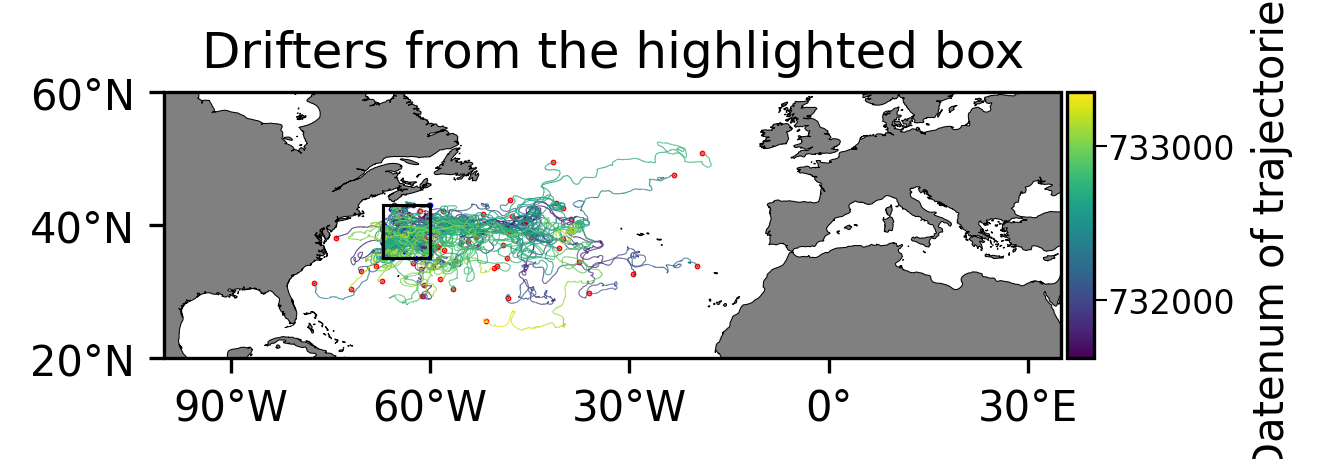

In [7]:
# plotting on a geographical map using cartopy
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect="equal")

# scatter of start/finish point
ax.scatter(
    segs[sid[:, 0], 0, 0], segs[sid[:, 0], 0, 1], s=0.15, color="b", zorder=1
)  # initial point of each trajectory
ax.scatter(
    segs[sid[:, 1] - 1, 1, 0], segs[sid[:, 1] - 1, 1, 1], s=0.15, color="r", zorder=1
)  # final point of each trajectory

# trajectory segments
segments = LineCollection(segs, transform=ccrs.PlateCarree(), linewidths=0.25)
segments.set_array(segs_t)
ax.add_collection(segments)

# plot filtering zone
p = Rectangle(
    (x_range[0], y_range[0]),
    np.diff(x_range)[0],
    np.diff(y_range)[0],
    fill=False,
    linewidth=0.75,
    zorder=2,
)

ax.add_patch(p)

# available function to plot the boundaries of each bin
ax.set_xlim([-100, 35])
ax.set_ylim([20, 60])
ax.set_title("Drifters from the highlighted box")
# ticks
ax.set_xticks([-90, -60, -30, 0, 30], crs=ccrs.PlateCarree())
ax.set_yticks([20, 40, 60], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor="grey", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(segments, cax=cax)
cb.ax.tick_params(which="major", labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label("Datenum of trajectories")